In [6]:
%matplotlib inline
import os
import random
import numpy as np
import matplotlib.pyplot 
from matplotlib.pyplot import imshow, imsave
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance

from sklearn.externals import joblib
from keras.preprocessing import image
import cv2
from PIL import Image

Using TensorFlow backend.


In [7]:

# loading saved classifier  
clf_sign = joblib.load('clf_sign.pkl') 
import os

# Loading model online 

In [8]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
print("Loaded model online")

Loaded model online


# loading model offline

In [9]:
# load json and create model
#json_file = open('prv_VGG16_architecture.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#from keras.models import model_from_json
#model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
#print("Loaded model from disk")

In [10]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #ret, thresh = cv2.threshold(np.array(img), 200, 255, cv2.THRESH_BINARY)
    #return thresh, x
    return img,x

In [11]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
#feat_extractor.summary()

# path for probable signatures identified by image processing methods 

In [72]:
images_path = "/home/pyimagesearch/Desktop/Signature_final/Test Documents/DETECTED/"
list_folders = os.listdir(images_path)
print(list_folders)
#i_path = images_path + list_folders[0] + "/prob_signature/"
#print(i_path)

['GATE11', 'h', 'c', 'cheque', '03', 'e', '02', 'scan2', 'scan3', 'g', '01', 'GATE18', 'scan1', 'f', 'd', 'b', 'GATE12', 'a']


In [73]:
# By running signature_level_1.py, we have already extracted probable signatures to DETECTED folder 

#images_path = 'C:/Users/1311921/Desktop/Signature_final/Test Documents/temp/GATE12/prob_stamps/'
images_path = "/home/pyimagesearch/Desktop/Signature_final/Test Documents/DETECTED/scan2/prob_signature/" 

In [74]:
max_num_images = 100
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]
print("keeping %d images to analyze" % len(images))

keeping 19 images to analyze


# Display and save the probable signature for classification 

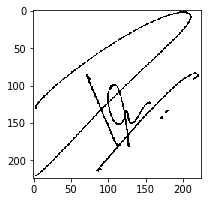

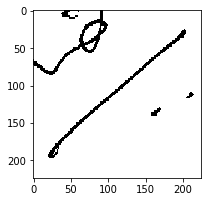

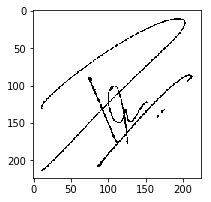

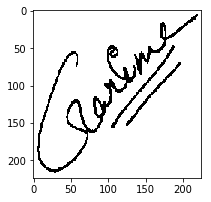

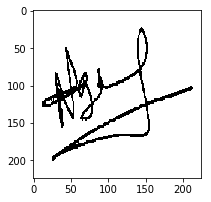

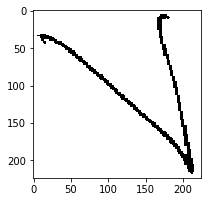

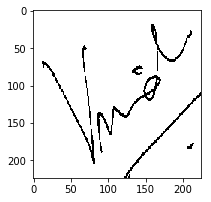

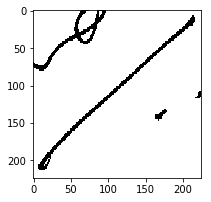

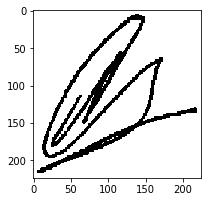

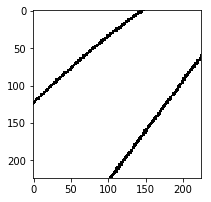

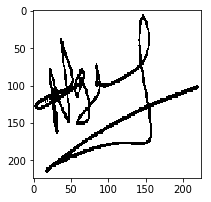

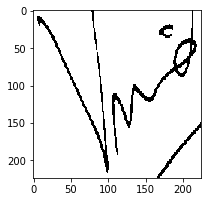

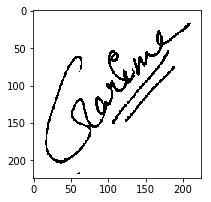

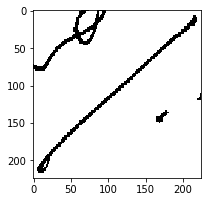

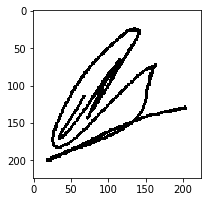

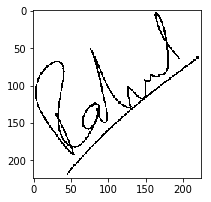

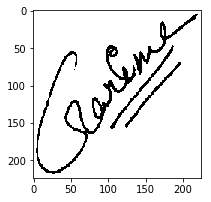

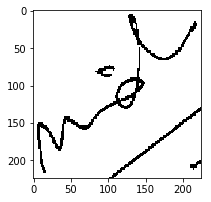

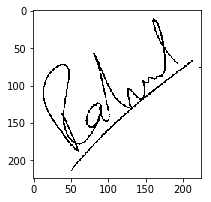

In [75]:
features = []
store_img = []
for image_path in (images):
    #print(image_path)
    
    img, x = get_image(image_path);    
    # display the resulting images
    matplotlib.pyplot.figure(figsize = (3,4))
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
    imshow(img)  
    store_img.append(img)
features = np.array(features)

# Classify wheather it is a sign or not 

In [76]:
#clf_sign.predict(features)

In [77]:
indices = [i for i, x in enumerate(clf_sign.predict(features)) if x == 1]
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [78]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [79]:
c=0
for image_path in (images):  
    #print(image_path)
    if c in indices:               
        img, x = get_image(image_path);        
        # display the resulting images
        #matplotlib.pyplot.figure(figsize = (4,4)) 
        #imshow(store_img[c])  
        sign_image_path = images_path + "Sign/"
        ensure_dir(sign_image_path)
        image_name = (sign_image_path +str(c) + ".png")
        ret, thresh = cv2.threshold(np.array(store_img[c]), 200, 255, cv2.THRESH_BINARY) 
        imsave(image_name, thresh)
    c = c+1

# Deep learning / CNN features extracted and check similarity

In [80]:
#reference_sign_database_path = 'C:/Users/1311921/Desktop/Signature_final/sample signs/'
reference_sign_database_path = "/home/pyimagesearch/Desktop/Signature_final/database reference signatures/"

In [81]:
# Reference signatures 

max_num_images = 35
#print(reference_sign_database_path)
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(reference_sign_database_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]   

print("keeping %d reference signatures to analyze" % len(images))

# Extracted signatures for testing 


#print(sign_image_path)
max_num_images = 35

S_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(sign_image_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    S_images = [S_images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]   

print("keeping %d test signatures to analyze" % len(S_images))

keeping 35 reference signatures to analyze
keeping 19 test signatures to analyze


In [82]:
features = []
for image_path in (images):
    img, x = get_image(image_path);    
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
 
test_features = []
for_display_test = []
for imagex in (S_images):
    img, x = get_image(imagex);
    for_display_test.append(img)
    feat_test = feat_extractor.predict(x)[0]
    test_features.append(feat_test)
    
pca_features = features

In [83]:
def get_closest_images(query_image_feat , name, num_results):
    distances = [ distance.euclidean(query_image_feat, feat) for feat in pca_features ]
    #print(distances)    
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:num_results]
    print("min distance sign: " + str(min(distances)))
    aaa = (np.argsort(distances)[:num_results])
    
    d = []
    for i in range(0,num_results):
        #print(distances[aaa[i]])
        d.append(distances[aaa[i]])
        
    # save to a text 

    text_file = open( name +".txt", "w")
    text_file.write("Similar Signatures based on similarity: \n"+ str(d))
    text_file.close()
    return idx_closest

def get_concatenated_images(indexes, name, thumb_height ):
    thumbs = []
    for idx in indexes:
        img = cv2.imread(images[idx],0)         
        img = Image.fromarray(img)
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    
    p = name + ".png"
    cv2.imwrite(p, concat_image)
    return concat_image

In [84]:
# automate for all

print(" If min distance < 40 : Match is perfect")
print(" If min distance < 60 & > 40  : Match is possible but chance of error high")
print(" If min distance > 60  : Similar signature not present or may be it is not even a valid signature")


for i in range(0,len(test_features)):
    query_image_idx = i
    print(query_image_idx)
    query_image_feat = test_features[query_image_idx]
    ensure_dir(sign_image_path + "SIMILARITY/")

    name = sign_image_path + "SIMILARITY/"+ "similar_to_" + str(query_image_idx)

    #print("Query image: ")
    #matplotlib.pyplot.figure(figsize = (4,4))
    #imshow(for_display_test[query_image_idx])
    imsave(name + "_original.png", for_display_test[query_image_idx])

    idx_closest = get_closest_images(query_image_feat , name, 3)

    results_image = get_concatenated_images(idx_closest, name ,400)
    #print("Similar Signatures based on similarity: ")
    #imshow(results_image)

 If min distance < 40 : Match is perfect
 If min distance < 60 & > 40  : Match is possible but chance of error high
 If min distance > 60  : Similar signature not present or may be it is not even a valid signature
0
min distance sign: 89.72541046142578
1
min distance sign: 0.0
2
min distance sign: 29.48182487487793
3
min distance sign: 21.4633846282959
4
min distance sign: 86.68346405029297
5
min distance sign: 41.897377014160156
6
min distance sign: 0.0
7
min distance sign: 20.51987648010254
8
min distance sign: 81.74539184570312
9
min distance sign: 0.0
10
min distance sign: 35.23149490356445
11
min distance sign: 71.99498748779297
12
min distance sign: 0.0
13
min distance sign: 0.0
14
min distance sign: 112.0118408203125
15
min distance sign: 56.93600845336914
16
min distance sign: 69.20865631103516
17
min distance sign: 21.851211547851562
18
min distance sign: 92.47406005859375


#### END #######